# SAM + CLIP Referring Image Segmentation Baseline

In [1]:
import numpy as np
import torch
import cv2
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
import clip
from tqdm import tqdm 
import os
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
cd /home/p300488/owg_stuff/OCID-VLG

/home/p300488/owg_stuff/OCID-VLG


In [3]:
%matplotlib inline
def display_image(path_or_array, size=(10, 10)):
  if isinstance(path_or_array, str):
    image = np.asarray(Image.open(open(image_path, 'rb')).convert("RGB"))
  else:
    image = path_or_array
  
  plt.figure(figsize=size)
  plt.imshow(image)
  plt.axis('off')
  plt.show()

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    # sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in anns:
        #m = ann['segmentation']
        m = ann.copy()
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.85)))

## Prepare dataset

In [5]:
from dataset import OCIDVLGDataset
data_dir = "/home/p300488/datasets/OCID_grasp"


#ds_val = OCIDVLGDataset(data_dir, "val", with_instance_mask=True, with_grasp_masks=False)
ds_test = OCIDVLGDataset(data_dir, "test", with_instance_mask=True, with_grasp_masks=False)

In [6]:
#s = ds_val[1]
s = ds_test[1]
print(s.keys())

dict_keys(['img', 'grasps', 'grasp_rects', 'sentence', 'target', 'bbox', 'target_idx', 'sent_id', 'scene_id', 'depth', 'mask_instance', 'mask'])


In [7]:
def prepare_ds(ds):
    # iterate over samples and save all queries per image, to run batched inference when evaluating
    result = {}
    i=0
    for sample in tqdm(ds):
        #sample = ds_val[i]
        img = sample['img']
        mask = sample['mask']
        if mask.sum() == 0:
            continue
        lang = sample['sentence'].lower().replace("the", "").strip()
        target = sample['target']
        scene_id = sample['scene_id']
        mask_instance = sample['mask_instance']
        # grasps = sample['grasps']
        # grasp_masks = sample['grasp_masks']
        if scene_id not in result.keys():
            result[scene_id] = {'img': img, 'queries': [lang], 'masks': [mask], 'masks_instance': [mask_instance], 'targets': [target]}
                               #'grasps': [grasps], 'grasp_masks': [grasp_masks]}
        else:
            result[scene_id]['queries'].append(lang)
            result[scene_id]['masks'].append(mask)
            result[scene_id]['masks_instance'].append(mask_instance)
            result[scene_id]['targets'].append(target)
            # result[scene_id]['grasps'].append(grasps)
            # result[scene_id]['grasp_masks'].append(grasp_masks)
        i+=1
        # if len(result) == 500:
        #     break
    return result

In [8]:
# ds_val = prepare_ds(ds_val)
ds_test = prepare_ds(ds_test)

100%|████████████████████████████████████| 18016/18016 [00:27<00:00, 665.76it/s]


In [9]:
#len(ds_val)
len(ds_test)

1510

In [10]:
# len(ds_val['ARID20/floor/bottom/seq13,result_2018-08-24-16-38-44.png']['masks'])

In [11]:
#pickle.dump(ds_val, open('./checkpoints/temp_ds_val_img_short.p', 'wb'))
pickle.dump(ds_val, open('./checkpoints/temp_ds_val_img.p', 'wb'))

# pickle.dump(ds_test, open('./checkpoints/ds_t_per_scene.p', 'wb'))

In [12]:
# ds_val = pickle.load(open('./checkpoints/temp_ds_val_img.p', 'rb'))
# ds_test = pickle.load(open('./checkpoints/temp_ds_test_img.p', 'rb'))

In [13]:
#ds_val = pickle.load(open('./checkpoints/temp_ds_val_img_short.p', 'rb'))
ds_val = pickle.load(open('./checkpoints/temp_ds_val_img.p', 'rb'))

## Load Model

In [22]:
from baselines.grounders.sam_and_clip import make_model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = make_model(device=device)

In [23]:
# metrics
from baselines.grounders.metrics import segmentation_metrics

In [1]:
# import torch
# from PIL import Image
# from transformers import SamModel, SamProcessor

# device = "cuda" if torch.cuda.is_available() else "cpu"
# model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
# processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

/home/p300488/owg_stuff/owg_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'SamModel' from 'transformers' (/home/p300488/owg_stuff/owg_venv/lib/python3.8/site-packages/transformers/__init__.py)

## Evaluate

In [28]:
# validation
def run_eval(ds):
    all_preds, all_masks = [], []
    i = 0
    for sample in tqdm(list(ds.values())):
        # img = sample['img']
        # queries = ';'.join(sample['queries'])
        # masks_gt = sample['masks']
        img, q, mask, _ = sample
        preds, _ = model.predict(img, q)
        all_preds.extend(preds[0])
        # all_masks.extend(masks_gt)
        all_masks.extend(mask)
        i += 1
    pickle.dump(all_preds, open('./checkpoints/temp_ds_val_preds_short.p', 'wb'))
    log_str, metrics = segmentation_metrics(all_preds, all_masks, device)
    print(log_str)
    print(metrics)
    return log_str, metrics, all_preds

In [29]:
log_str, metrics, all_preds = run_eval(ds_val)

  1%| | 9/1464 [0


KeyboardInterrupt: 

## CLIP utils

In [9]:
def article(name):
  return 'an' if name[0] in 'aeiou' else 'a'

def processed_name(name, rm_dot=False):
  # _ for lvis
  # / for obj365
  res = name.replace('_', ' ').replace('/', ' or ').lower()
  if rm_dot:
    res = res.rstrip('.')
  return res

single_template = [
    'a photo of {article} {}.'
]

multiple_templates = [
    'There is {article} {} in the scene.',
    'There is the {} in the scene.',
    'a photo of {article} {} in the scene.',
    'a photo of the {} in the scene.',
    'a photo of one {} in the scene.',


    'itap of {article} {}.',
    'itap of my {}.',  # itap: I took a picture of
    'itap of the {}.',
    'a photo of {article} {}.',
    'a photo of my {}.',
    'a photo of the {}.',
    'a photo of one {}.',
    'a photo of many {}.',

    'a good photo of {article} {}.',
    'a good photo of the {}.',
    'a bad photo of {article} {}.',
    'a bad photo of the {}.',
    'a photo of a nice {}.',
    'a photo of the nice {}.',
    'a photo of a cool {}.',
    'a photo of the cool {}.',
    'a photo of a weird {}.',
    'a photo of the weird {}.',

    'a photo of a small {}.',
    'a photo of the small {}.',
    'a photo of a large {}.',
    'a photo of the large {}.',

    'a photo of a clean {}.',
    'a photo of the clean {}.',
    'a photo of a dirty {}.',
    'a photo of the dirty {}.',

    'a bright photo of {article} {}.',
    'a bright photo of the {}.',
    'a dark photo of {article} {}.',
    'a dark photo of the {}.',

    'a photo of a hard to see {}.',
    'a photo of the hard to see {}.',
    'a low resolution photo of {article} {}.',
    'a low resolution photo of the {}.',
    'a cropped photo of {article} {}.',
    'a cropped photo of the {}.',
    'a close-up photo of {article} {}.',
    'a close-up photo of the {}.',
    'a jpeg corrupted photo of {article} {}.',
    'a jpeg corrupted photo of the {}.',
    'a blurry photo of {article} {}.',
    'a blurry photo of the {}.',
    'a pixelated photo of {article} {}.',
    'a pixelated photo of the {}.',

    'a black and white photo of the {}.',
    'a black and white photo of {article} {}.',

    'a plastic {}.',
    'the plastic {}.',

    'a toy {}.',
    'the toy {}.',
    'a plushie {}.',
    'the plushie {}.',
    'a cartoon {}.',
    'the cartoon {}.',

    'an embroidered {}.',
    'the embroidered {}.',

    'a painting of the {}.',
    'a painting of a {}.',
]

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

In [11]:
def build_text_embedding(categories, prompt_engineering=True, this_is=True):
  if prompt_engineering:
    templates = multiple_templates
  else:
    templates = single_template

  with torch.no_grad():
    all_text_embeddings = []
    #print('Building text embeddings...')
    for category in categories:
      texts = [
        template.format(processed_name(category['name'], rm_dot=True),
                        article=article(category['name']))
        for template in templates]
      if this_is:
        texts = [
                 'This is ' + text if text.startswith('a') or text.startswith('the') else text 
                 for text in texts
                 ]
      texts = clip.tokenize(texts).to(device) #tokenize
      text_embeddings = model.encode_text(texts) #embed with text encoder
      text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)
      text_embedding = text_embeddings.mean(dim=0) #average accross prompt templates
      text_embedding /= text_embedding.norm()
      all_text_embeddings.append(text_embedding)
    all_text_embeddings = torch.stack(all_text_embeddings, dim=1)
    
  return all_text_embeddings.to(device).T

In [12]:
def get_clip_visual_features(image, boxes, masks):
    object_image_features = []
    for b, m in zip(boxes, masks):
        # ReCLIP style - both mask and crop
        # segm = m['segmentation']
        segm = m.copy()
        mask = np.ones_like(image) * 0xff
        #mask = image.copy()
        mask[segm==True] = image[segm==True]
        mask_input = preprocess(Image.fromarray(mask)).to(device)

        x1,y1,x2,y2 = b
        crop_box = image[y1:y2, x1:x2, :]
        box_input = preprocess(Image.fromarray(crop_box)).to(device)

        image_inputs = torch.stack([mask_input, box_input])
        #image_inputs = mask_input.unsqueeze(0)
        #image_inputs = box_input.unsqueeze(0)
        
        image_features = model.encode_image(image_inputs)
        image_features_norm = image_features / image_features.norm(dim=1, keepdim=True)
        object_image_features.append(image_features_norm)

    #object_image_features = torch.stack(object_image_features).mean(1)
    object_image_features = torch.stack(object_image_features)
    return object_image_features

In [13]:
def clip_get_most_similar(object_image_features, category_name_string, masks, image, prompt_engineerimg, this_is, show=True):
    N, V, C = object_image_features.shape
    object_image_features = object_image_features.view(N*V, C).contiguous()
    
    # Preprocessing categories and get params
    category_names = [x.strip() for x in category_name_string.split(';')]
    categories = [{'name': item, 'id': idx+1,} for idx, item in enumerate(category_names)]
    
    text_embedding = build_text_embedding(categories, prompt_engineerimg, this_is) # (Q, C)
    #Q, T, C = text_embedding.shape
    #text_embedding = text_embedding.view(Q*T, C).contiguous()

    similarities = object_image_features @ text_embedding.T # (NV, Q)
    similarities = similarities.view(N, V, -1).mean(dim=1)
    most_similar_indices =  similarities.argmax(0)
    # most_similar_indices =  similarities.squeeze().argmax(0).cpu().numpy()
    
    if show:
        for prompt, index in zip(category_names, most_similar_indices):
            print(prompt)
            plt.figure(figsize=(10,10))
            plt.imshow(image)
            show_anns([masks[index]])
            plt.axis('off')
            plt.show() 
    
    return [masks[i] for i in most_similar_indices]



## CLIP with ground truth masks

In [15]:
def bounding_rect(msk):
    cs, _ = cv2.findContours(255 * msk.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cs = sorted(cs, key=lambda c: cv2.contourArea(c), reverse=True)[0]
    x, y, w, h = cv2.boundingRect(cs)
    return x,y,x+w,y+h

In [15]:
# validation
from baselines.grounders.metrics import segmentation_metrics

def run_eval(ds, prompt_engineerimg, this_is):
    all_preds, all_masks = [], []
    i = 0
    for sample in tqdm(list(ds.values())):
        img = sample['img']
        masks_gt = sample['masks']
        mask_inst = sample['masks_instance'][0]
        queries = ';'.join(sample['queries'])
        
        assert [m.sum() > 0 for m in masks_gt]
        
        # separate instance masks
        obj_ids = np.unique(mask_inst)[1:] # exclude background
        masks_input = [np.where(mask_inst == ID, True, False) for ID in obj_ids]
        boxes_input = [bounding_rect(m) for m in masks_input]
        
        obj_feats = get_clip_visual_features(img, boxes_input, masks_input)
        pred_masks = clip_get_most_similar(obj_feats, queries, masks_input, img, prompt_engineerimg, this_is, show=False)
        all_preds.extend(pred_masks)
        all_masks.extend(masks_gt)
        i += 1
        # if i == 100:
        #     break
    pickle.dump(all_preds, open('./checkpoints/temp_ds_val_preds_short.p', 'wb'))
    log_str, metrics = segmentation_metrics(all_preds, all_masks, device)
    print(log_str)
    print(metrics)
    return log_str, metrics, all_preds, all_masks

In [21]:
log_str, metrics, all_preds, all_masks = run_eval(ds_val, False, True)

100%|█| 1457/1457


Evaluation: IoU=41.26  Pr@50: 41.38  Pr@60: 41.11  Pr@70: 40.87  Pr@80: 40.86  Pr@90: 40.86  
{'iou': 0.412592425030993, 'Pr@50': 0.41377556324005127, 'Pr@60': 0.41106116771698, 'Pr@70': 0.4086860716342926, 'Pr@80': 0.4086012542247772, 'Pr@90': 0.4086012542247772}


In [15]:
torch.cuda.empty_cache()

In [23]:
log_str, metrics, all_preds, all_masks = run_eval(ds_test, False, True)

100%|█| 1510/1510


Evaluation: IoU=40.76  Pr@50: 40.90  Pr@60: 40.63  Pr@70: 40.42  Pr@80: 40.41  Pr@90: 40.40  
{'iou': 0.40757518568062323, 'Pr@50': 0.40904700756073, 'Pr@60': 0.406319260597229, 'Pr@70': 0.404159814119339, 'Pr@80': 0.40410298109054565, 'Pr@90': 0.4040461480617523}


## CLIP with SAM masks

In [14]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [15]:
# del sam, mask_generator
# torch.cuda.empty_cache()

In [16]:
sam = sam_model_registry["vit_b"](checkpoint="checkpoints/sam_vit_b_01ec64.pth").cuda()
mask_generator = SamAutomaticMaskGenerator(sam)

# mask_generator = SamAutomaticMaskGenerator(
#     model=sam,
#     points_per_side=64,
#     pred_iou_thresh=0.9,
#     stability_score_thresh=0.98,
#     crop_n_layers=1,
#     crop_n_points_downscale_factor=2,
#     min_mask_region_area=10000,  # Requires open-cv to run post-processing
# )

In [17]:
# for sample in tqdm(list(ds_val.values())):
#         # SAM
#         with torch.no_grad():
#             masks = mask_generator.generate(sample['img'])
#         torch.cuda.empty_cache()
        
#         boxes_input = [ (m['bbox'][0], m['bbox'][1], m['bbox'][0]+m['bbox'][2], m['bbox'][1] + m['bbox'][2]) for m in masks]
#         masks_input = [ m['segmentation'] for m in masks]
        
#         sample['box_input'] = boxes_input
#         sample['mask_input'] = masks_input

In [ ]:
torch.save(ds_val, "checkpoints/sam_masks_val.p")

In [17]:
    # validation
    from baselines.grounders.metrics import segmentation_metrics
    prompt_engineerimg = False
    this_is = True

    # def run_eval(ds, prompt_engineerimg, this_is):
    all_preds, all_masks = [], []
    i = 0
    for sample in tqdm(list(ds_val.values())):
        img = sample['img']
        masks_gt = sample['masks']

        queries = ';'.join(sample['queries'])
        
        assert [m.sum() > 0 for m in masks_gt]
        
        # SAM
        torch.cuda.empty_cache()
        with torch.no_grad():
            masks = mask_generator.generate(sample['img'])
        torch.cuda.empty_cache()
        
        boxes_input = [ (int(m['bbox'][0]), int(m['bbox'][1]), 
                         int(m['bbox'][0]+m['bbox'][2]), 
                         int(m['bbox'][1] + m['bbox'][2])) for m in masks]
        masks_input = [ m['segmentation'] for m in masks]
        del masks
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            try:
                obj_feats = get_clip_visual_features(img, boxes_input, masks_input)
            except TypeError:
                print(boxes_input)
            pred_masks = clip_get_most_similar(obj_feats, queries, masks_input, img, prompt_engineerimg, this_is, show=False)
            all_preds.extend(pred_masks)
            all_masks.extend(masks_gt)
        i += 1
        # if i == 100:
        #     break
    #pickle.dump(all_preds, open('./checkpoints/temp_ds_val_preds_short.p', 'wb'))
    log_str, metrics = segmentation_metrics(all_preds, all_masks, device)
    print(log_str)
    print(metrics)
    #return log_str, metrics, all_preds, all_masks

100%|█| 1457/1457


Evaluation: IoU=29.94  Pr@50: 34.17  Pr@60: 32.94  Pr@70: 31.93  Pr@80: 24.69  Pr@90: 5.98  
{'iou': 0.29937463064180814, 'Pr@50': 0.34167444705963135, 'Pr@60': 0.32937484979629517, 'Pr@70': 0.3192806839942932, 'Pr@80': 0.24692510068416595, 'Pr@90': 0.05980151146650314}


In [18]:
    # validation
    from baselines.grounders.metrics import segmentation_metrics
    prompt_engineerimg = False
    this_is = True

    # def run_eval(ds, prompt_engineerimg, this_is):
    all_preds, all_masks = [], []
    i = 0
    for sample in tqdm(list(ds_test.values())):
        img = sample['img']
        masks_gt = sample['masks']

        queries = ';'.join(sample['queries'])
        
        assert [m.sum() > 0 for m in masks_gt]
        
        # SAM
        torch.cuda.empty_cache()
        with torch.no_grad():
            masks = mask_generator.generate(sample['img'])
        torch.cuda.empty_cache()
        
        boxes_input = [ (int(m['bbox'][0]), int(m['bbox'][1]), 
                         int(m['bbox'][0]+m['bbox'][2]), 
                         int(m['bbox'][1] + m['bbox'][2])) for m in masks]
        masks_input = [ m['segmentation'] for m in masks]
        del masks
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            try:
                obj_feats = get_clip_visual_features(img, boxes_input, masks_input)
            except TypeError:
                print(boxes_input)
            pred_masks = clip_get_most_similar(obj_feats, queries, masks_input, img, prompt_engineerimg, this_is, show=False)
            all_preds.extend(pred_masks)
            all_masks.extend(masks_gt)
        i += 1
        # if i == 100:
        #     break
    #pickle.dump(all_preds, open('./checkpoints/temp_ds_val_preds_short.p', 'wb'))
    log_str, metrics = segmentation_metrics(all_preds, all_masks, device)
    print(log_str)
    print(metrics)
    #return log_str, metrics, all_preds, all_masks

100%|█| 1510/1510


Evaluation: IoU=30.28  Pr@50: 34.61  Pr@60: 33.42  Pr@70: 32.28  Pr@80: 25.30  Pr@90: 5.77  
{'iou': 0.3028395184750244, 'Pr@50': 0.3461385667324066, 'Pr@60': 0.33420470356941223, 'Pr@70': 0.3227823078632355, 'Pr@80': 0.25299766659736633, 'Pr@90': 0.05768028646707535}


In [ ]:
log_str, metrics, all_preds, all_masks = run_eval(ds_test, False, True)

In [33]:
del sam, model, preprocess, mask_generator; torch.cuda.empty_cache()

In [38]:
sample.keys(), len(sample['queries'])

(dict_keys(['img', 'queries', 'masks', 'masks_instance', 'targets']), 2)

(480, 640)


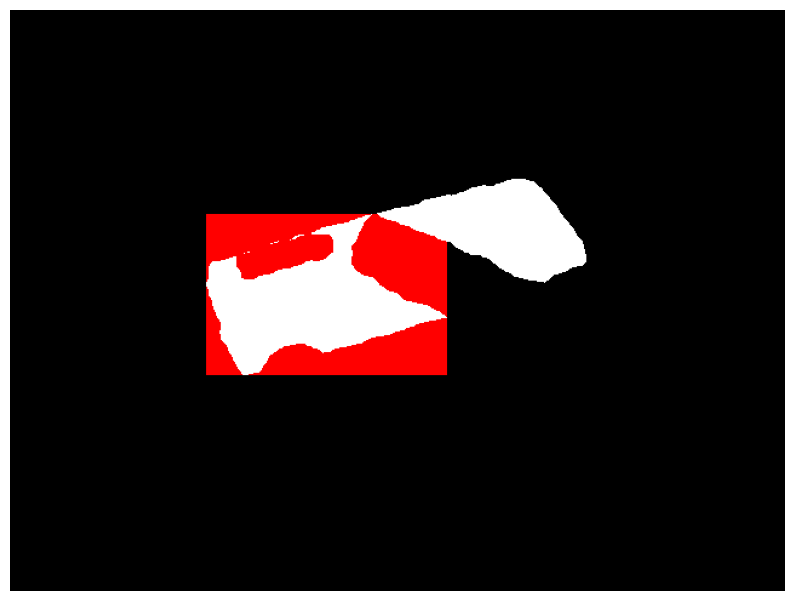

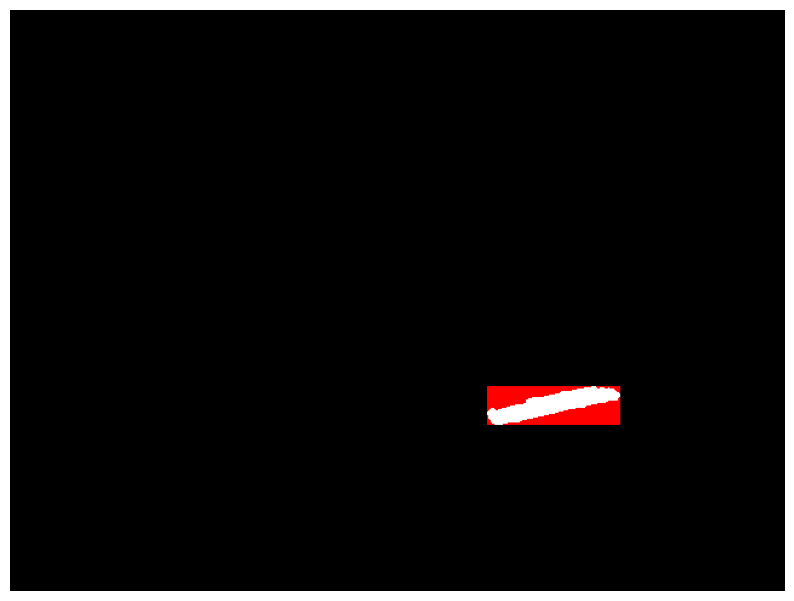

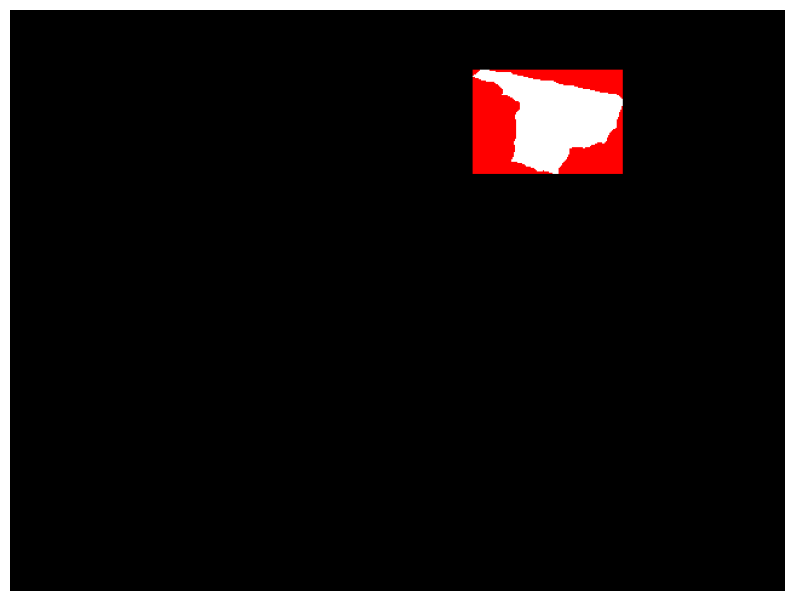

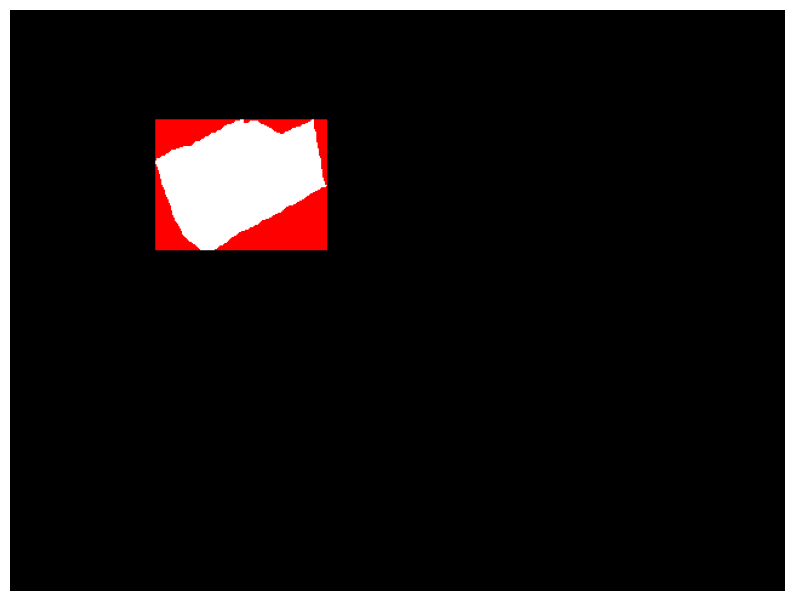

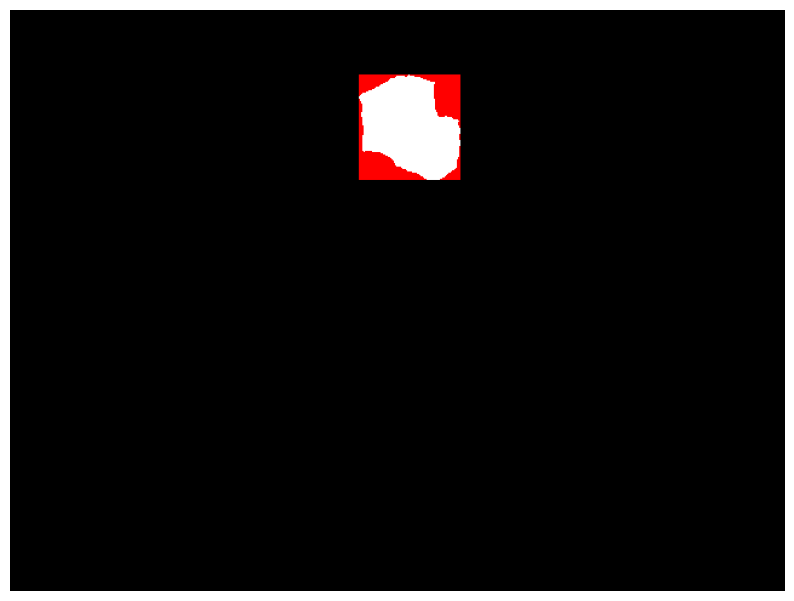

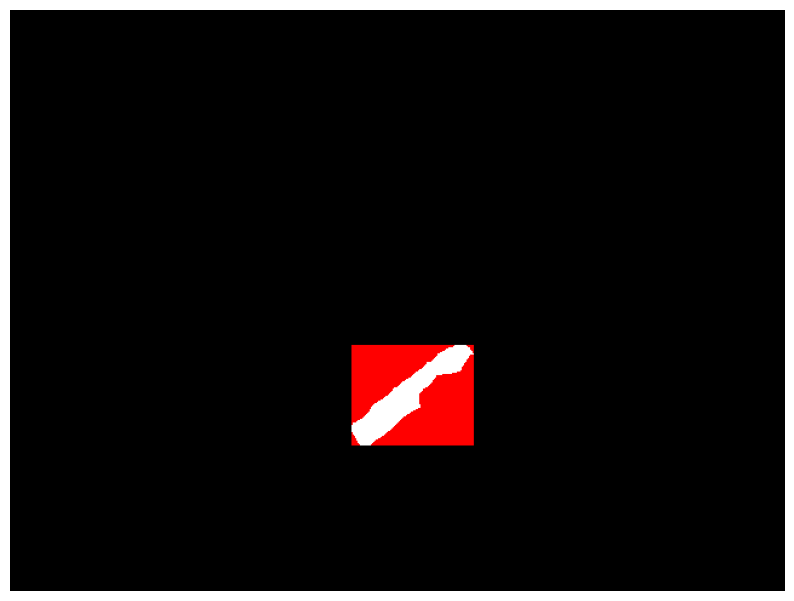

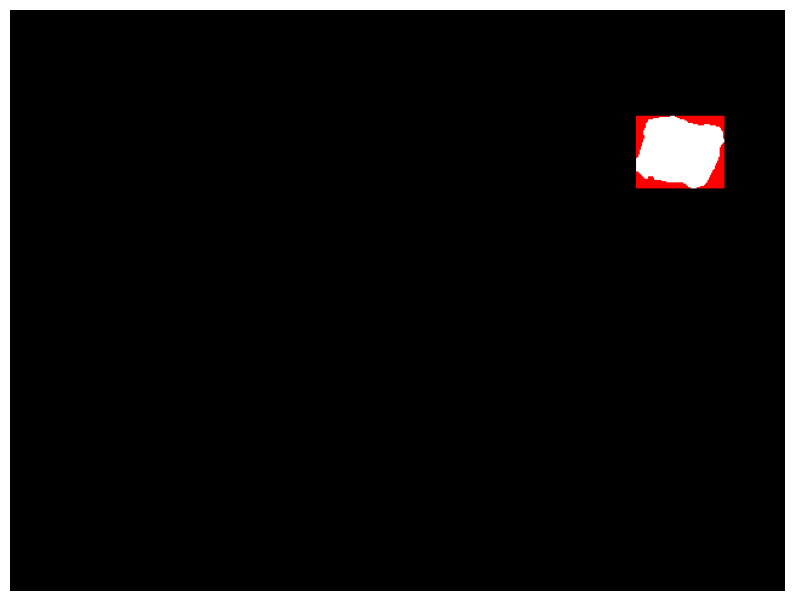

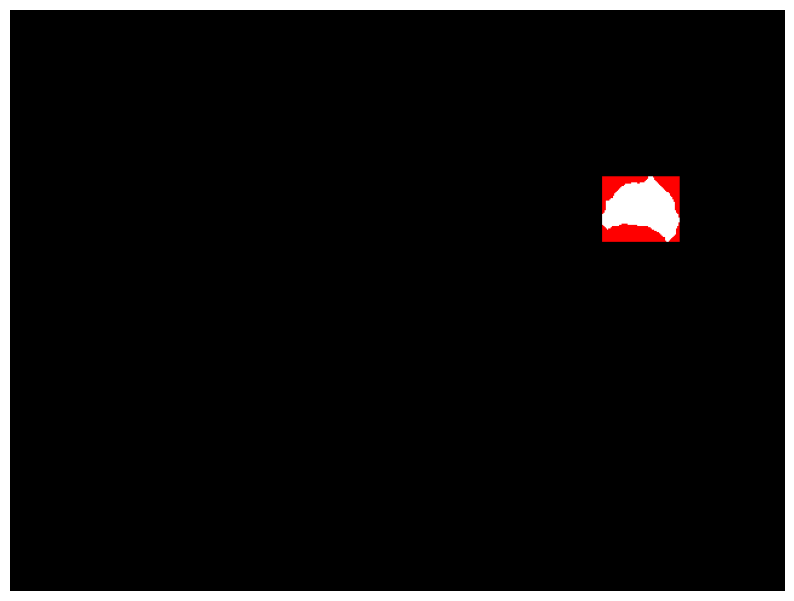

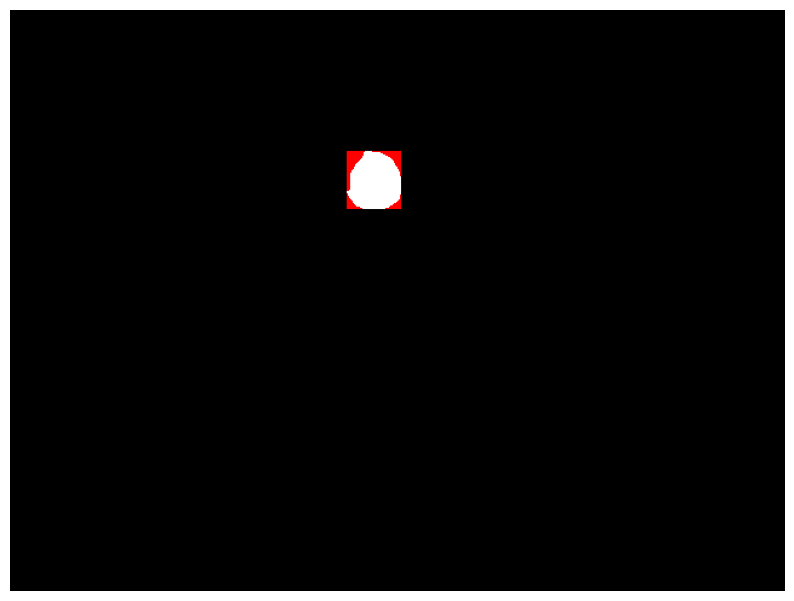

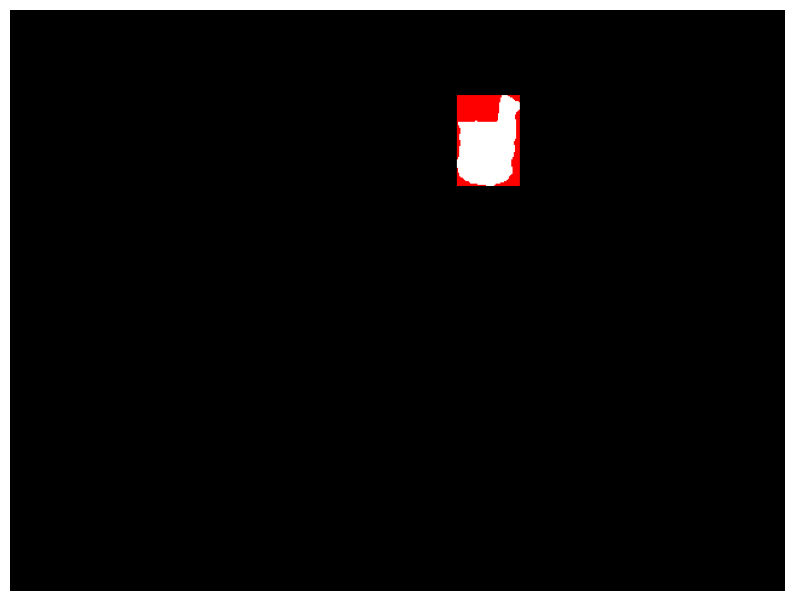

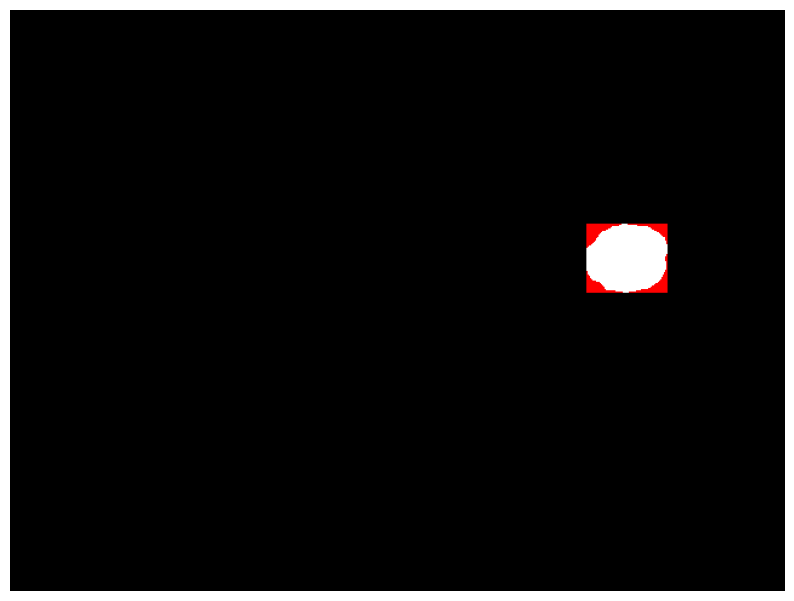

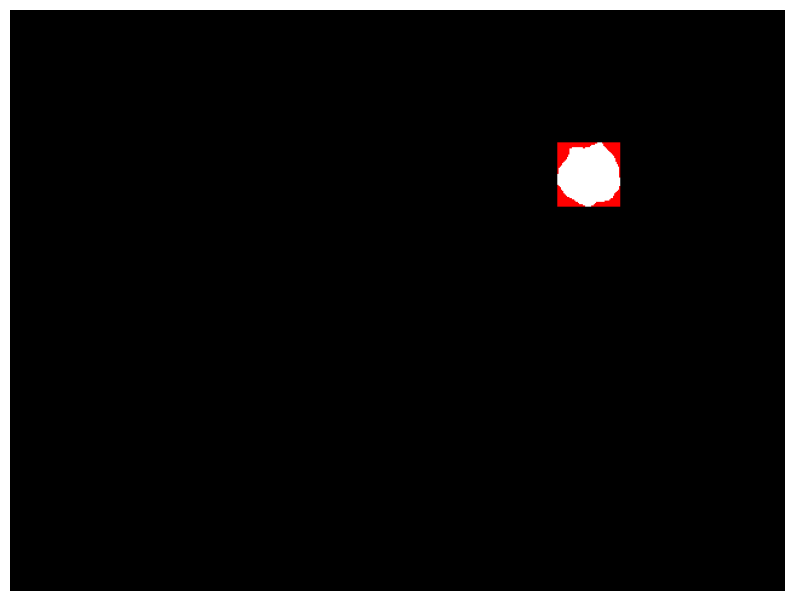

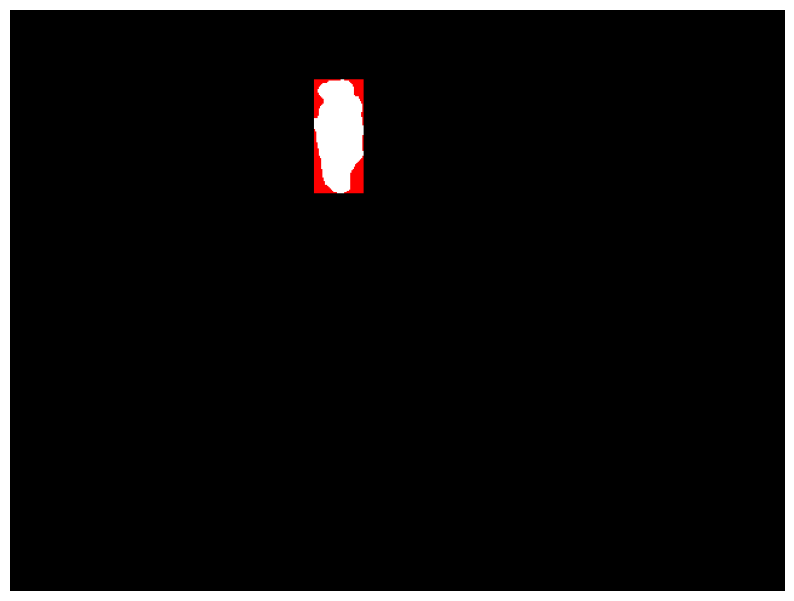

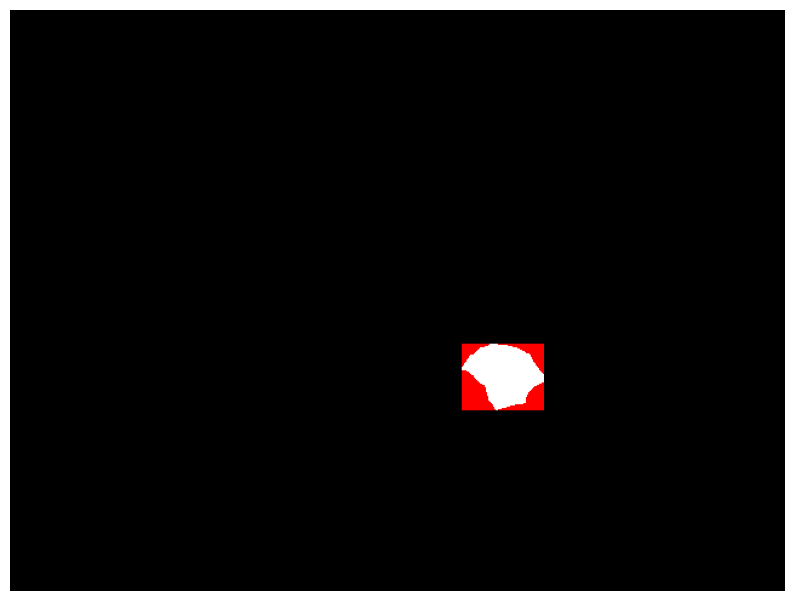

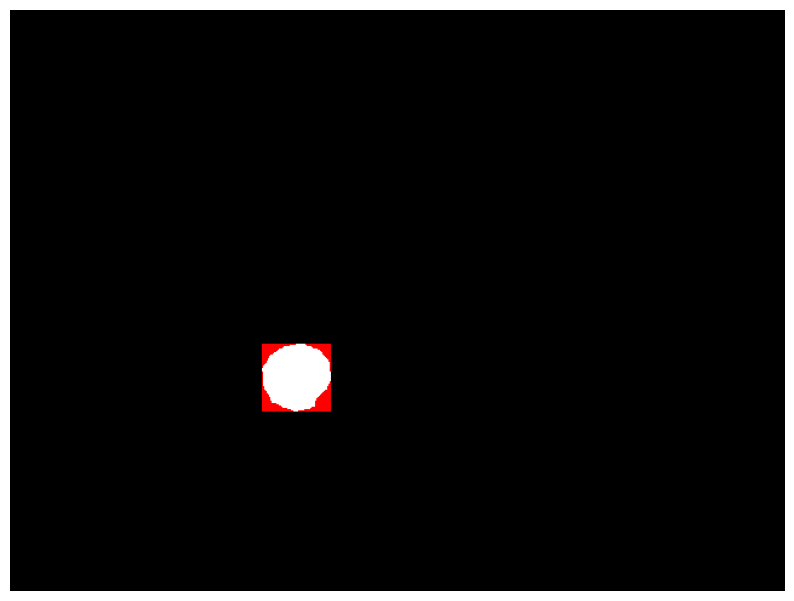

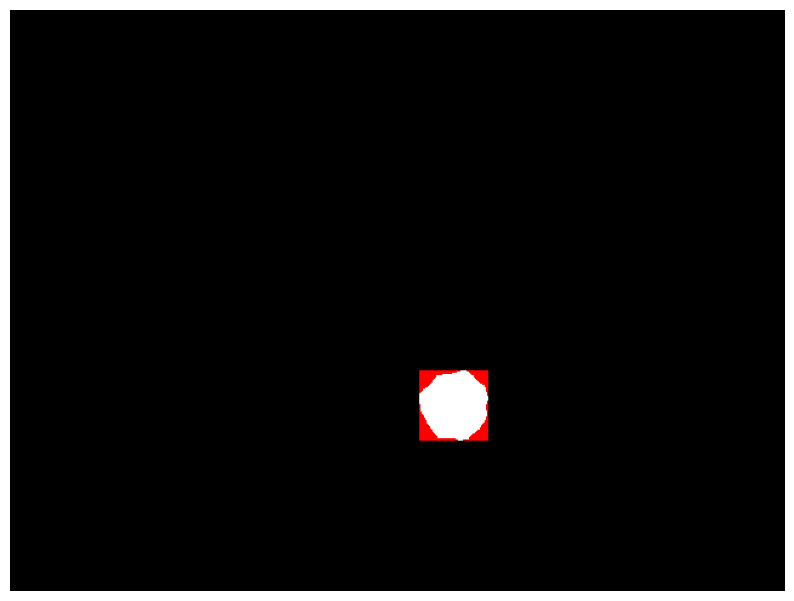

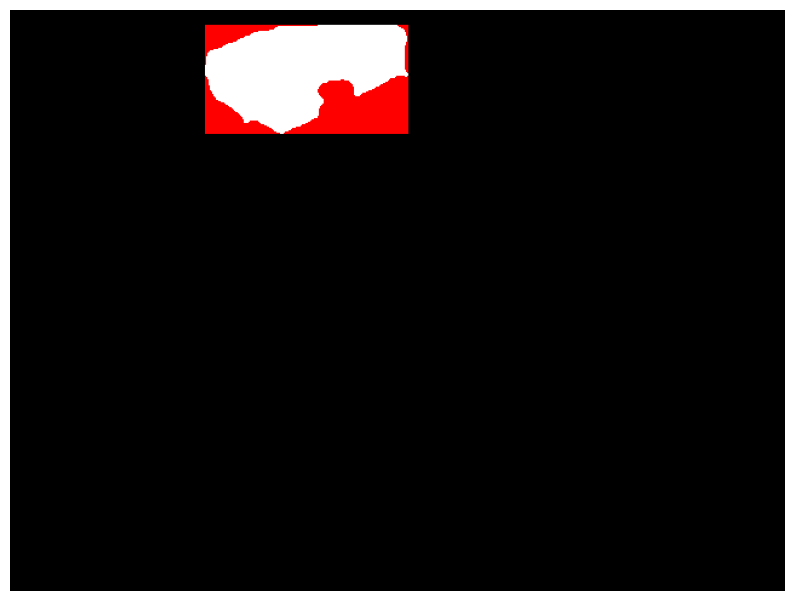

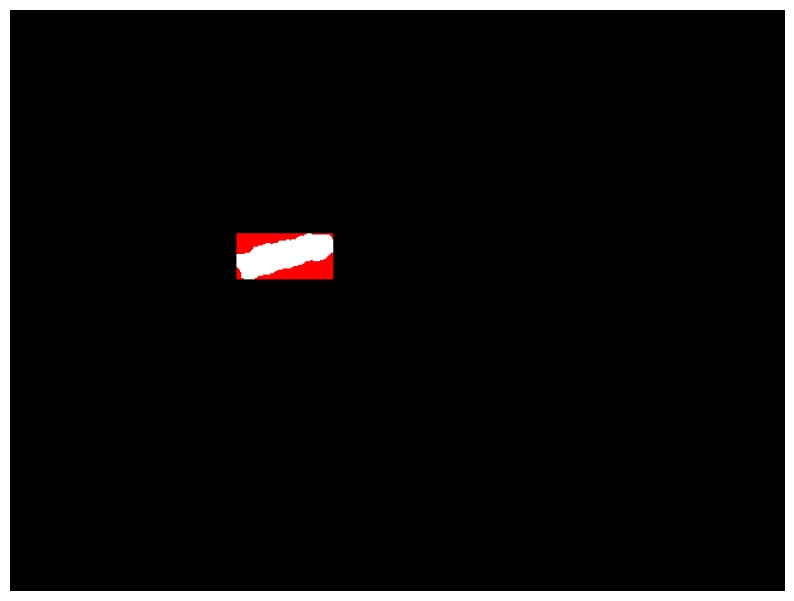

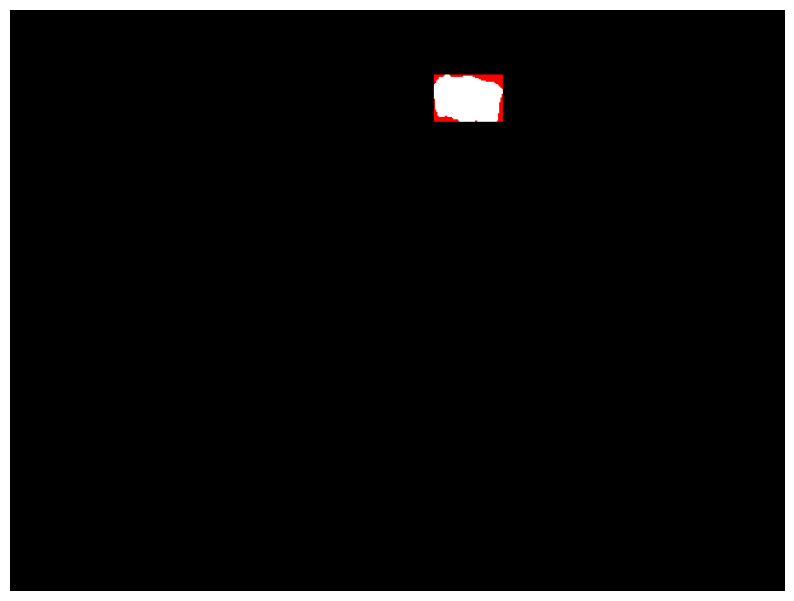

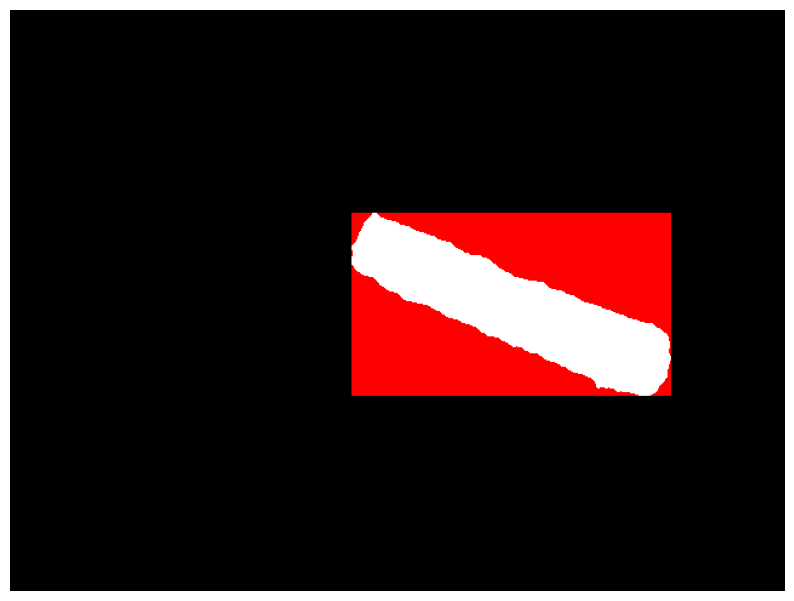

In [39]:
# separate instance masks
mask_inst = sample['masks_instance'][0]
print(mask_inst.shape)
obj_ids = np.unique(mask_inst)[1:] # exclude background
masks_input = [np.where(mask_inst == ID, True, False) for ID in obj_ids]
box_input = [bounding_rect(m) for m in masks_input]

for b,m in zip(box_input, masks_input):
    m = 255 * m.astype(np.uint8)
    m = cv2.merge([m,m,m])
    x1,y1,x2,y2 = b
    m[y1:y2,x1:x2, 0] = 255
    display_image(m)

In [40]:
set([len(s['queries']) for s in ds_val.values()])

{1, 2, 3, 4, 5}

In [41]:
len(ds_val)

500

In [43]:
x = get_clip_visual_features(sample['img'], box_input,  masks_input)

In [44]:
x.shape

torch.Size([20, 512])

beige hand towel on  rear left of  green white marker.


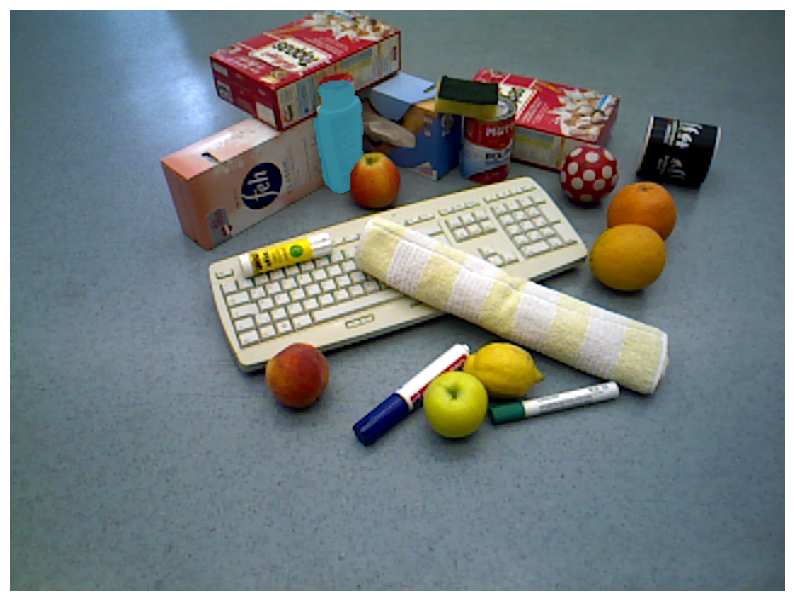

shampoo on  front left of  cereal box.


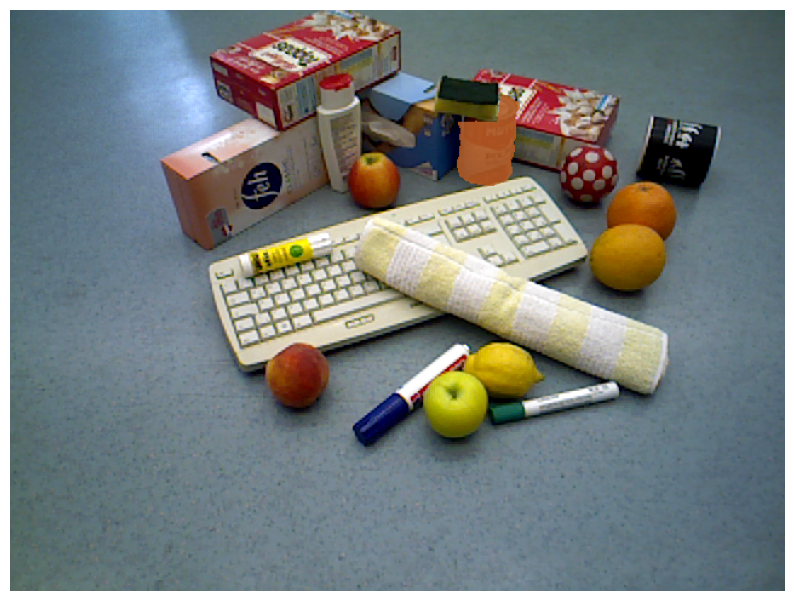

In [45]:
qs = ';'.join(sample['queries'])
out = clip_get_most_similar(x, qs, masks_input, sample['img'], prompt_engineerimg=False, this_is=False, show=True)

In [46]:
masks_gt = sample['masks']
print(len(masks_gt), masks_gt[0].shape, masks_gt[0].dtype)

2 (480, 640) bool


In [47]:
out[0].shape, out[0].dtype

((480, 640), dtype('bool'))

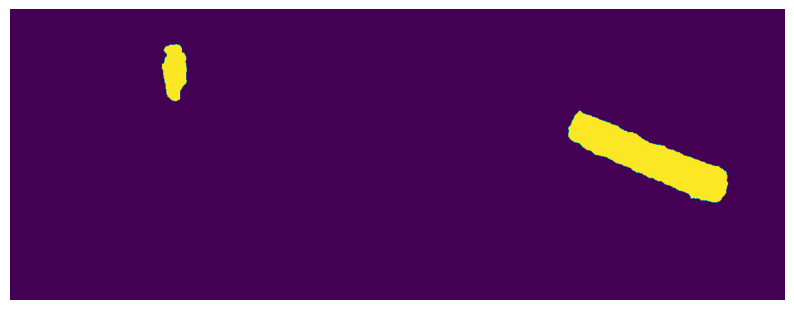

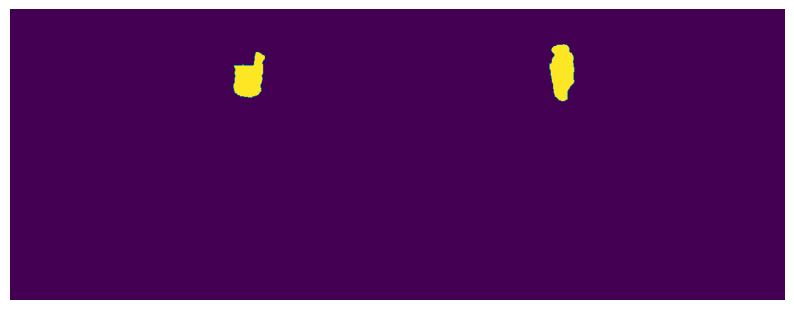

In [48]:
display_image(np.hstack([out[0], masks_gt[0]]))
display_image(np.hstack([out[1], masks_gt[1]]))